# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

training_file = 'train.p'
validation_file= 'valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train_init, y_train_init = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# Ensure that geatures and the labels have the same size
assert(len(X_train_init) == len(y_train_init))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
import numpy as np
import pandas as pd
import sklearn as sk

In [3]:
# Number of training examples
n_train = len(X_train_init)

# Number of validation examples
n_validation = len(X_valid)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train_init[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(pd.unique(y_train_init))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [4]:
X_train_init.shape

(34799, 32, 32, 3)

### Exploratory visualization of the dataset

In [5]:
import random
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline

In [6]:
list_signals = pd.read_csv('signnames.csv')

list_signals.head()

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


Yield


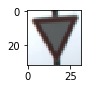

In [7]:
# Show a random image from the dataset
index = random.randint(0, len(X_train_init))
image = X_train_init[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image)
print(list_signals['SignName'][y_train_init[index]])

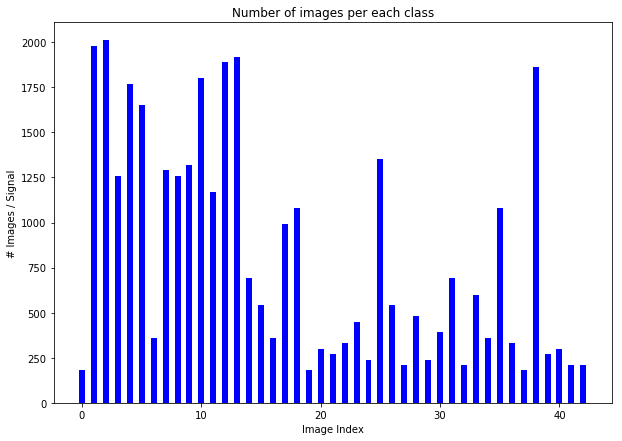

In [8]:
count = pd.value_counts(y_train_init).sort_index()

def stats_barchart(train_labels, n_classes, count):
    ind = np.arange(n_classes)  # the x locations for the groups
    width = 0.5       # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 7))
    rects1 = ax.bar(ind, count, width, color='b')

    ax.set_xlabel('Image Index')
    ax.set_ylabel('# Images / Signal')
    ax.set_title('Number of images per each class')

    plt.show()
    
stats_barchart(y_train_init, n_classes, count)

In [9]:
result = pd.DataFrame()
result['SignIndex'] = count.index
result['Counts'] = count.values
result['Signal'] = list_signals['SignName'][count.index]

result = result.sort_values(by=['Counts'], ascending=True)
result = result.reset_index(drop=True)

result.head(n=n_classes)

,SignIndex,Counts,Signal
0,0,180,Speed limit (20km/h)
1,37,180,Go straight or left
2,19,180,Dangerous curve to the left
3,32,210,End of all speed and passing limits
4,27,210,Pedestrians
5,41,210,End of no passing
6,42,210,End of no passing by vehicles over 3.5 metric ...
7,24,240,Road narrows on the right
8,29,240,Bicycles crossing
9,39,270,Keep left


In [10]:
print("Less repeated signal: ", result['Signal'][0])
print("Most repeated signal: ", result['Signal'][n_classes-1])

Less repeated signal:  Speed limit (20km/h)
Most repeated signal:  Speed limit (50km/h)


In [11]:
mean = result['Counts'].mean()

In [12]:
### What I'm doing here is to increase later the less repeated objects of the dataset
less_repeated = result[result.Counts<mean].SignIndex.items()

less = []

#print(less_repeated[1])

for signal_index in less_repeated:
    signal_count = result[result.SignIndex==signal_index[1]].Counts.item()
    less.append([signal_index[1],signal_count])

less = np.asarray(less)



----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set

In [13]:
import cv2
from pylab import arange
from math import ceil
from sklearn.utils import shuffle

def show2img(orig_img, proc_img):
    plt.figure(figsize=(6, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(orig_img)
    plt.title("Original image")
    plt.subplot(1, 2, 2)
    plt.imshow(proc_img)
    plt.title("Processed image")
    plt.show()

In [14]:
def gaussian_blur(img, kernel_size=5):
    """
    Applies a Gaussian Noise kernel of default size 5
    """
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def grayscale(img):
    """
    Applies a Grayscale Transformation
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


def normalize(img):
    norm_img = img.copy()
    
    cv2.normalize(img, dst=norm_img, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    return norm_img


def histogram_eq(img):
    #Histogram Equalization
    eq_img=img.copy() 
    eq_img[...,0] = cv2.equalizeHist(img[:, :, 0])
    eq_img[...,1]= cv2.equalizeHist(img[:, :, 1])
    eq_img[:, :, 2] = cv2.equalizeHist(img[:, :, 2])
    return eq_img


def adap_histogram_eq(img, clip=2.0, grid=8):
    # Convert the RGB image into LAB  
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Contrast Limited Adaptive Histogram Equalization
    clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=(grid,grid))
    cl = clahe.apply(gray_img)    

    final = cv2.cvtColor(cl, cv2.COLOR_GRAY2BGR)
    
    return final


def contrast_lab(img, clip=2.0, grid=8):
    # Convert the RGB image into LAB  
    lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    
    # Split the LAB image to different channels
    l, a, b = cv2.split(lab_img)

    # Apply Contrast Limited Adaptive Histogram Equalization
    clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=(grid,grid))
    cl = clahe.apply(l)    

    # Merge the CLAHE enhanced L-channel with the a and b channel
    limg = cv2.merge((cl,a,b))

    # Convert image from LAB Color model into RGB 
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

    return final


def sharpen_img(img):
    gauss_image = gaussian_blur(img, kernel_size=3)
    return cv2.addWeighted(img, 2, gauss_image, -1, 0)

def lin_img(img,s=1.0,m=0.0):
    img2=cv2.multiply(img, np.array([s]))
    return cv2.add(img2, np.array([m]))


def weighted_image(initial_img, mod_img, α=0.8, β=0.4, λ=0.0):
    return cv2.addWeighted(initial_img, α, mod_img, β, λ)

def contr_img(img, s=1.0):
    m=127.0*(1.0-s)
    return lin_img(img, s, m)

def brightness(img):
    maxIntensity = 255.0 
    x = arange(maxIntensity) 

    # Parameters for manipulating image data
    phi = 1
    theta = 1

    # Decrease intensity such that
    # dark pixels become much darker, 
    # bright pixels become slightly dark 
    darkened_image = (maxIntensity/phi)*(img/(maxIntensity/theta))**0.5
    darkened_image = np.array(darkened_image, dtype='uint8')
    
    return darkened_image

In [15]:
def random_resize(img, max_pixels=2):
    len_x = img[0].shape[0]
    len_y = img[1].shape[0]
    
    pixels = random.randint(0, max_pixels)
    
    #cropped_image = img[2:30, 2:30]
    cropped_image = img[pixels:len_y-pixels, pixels:len_y-pixels]
    resized_image = cv2.resize(cropped_image, (32, 32))
    
    return resized_image


def rotation(img, max_angle):
    # Rotation between -max_angle and max_angle degrees    
    angle = random.randint(-max_angle, max_angle)
    
    rows, cols,ch = img.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
    
    return(cv2.warpAffine(img,M,(cols,rows)))


def random_perspective(img):
    rows,cols,ch = img.shape
    
    small1 = random.randint(0, 5)
    small2 = random.randint(0, 5)
    big1 = random.randint(27, 32)
    big2 = random.randint(27, 32)
    
    pts1 = np.float32([[small1,small2],[big1,small1],[small2,big2],[big1,big2]])
    pts2 = np.float32([[small2,small1],[big2,small2],[small1,big1],[big2,big1]])
    
    M = cv2.getPerspectiveTransform(pts1,pts2)
    
    return(cv2.warpPerspective(img,M,(32,32)))  


def random_affine(img):
    
    rows,cols,ch = img.shape
    
    small1 = random.randint(0, 5)
    small2 = random.randint(0, 5)
    big1 = random.randint(27, 32)
    big2 = random.randint(27, 32)
    
    pts1 = np.float32([[small1,small1],[big1,small2],[small1,big1]])
    pts2 = np.float32([[small2,small2],[big2,small1],[small2,big2]])
    M = cv2.getAffineTransform(pts1,pts2)
    return(cv2.warpAffine(img,M,(cols,rows)))


def random_transform(img):
    max_angle = 15
    
    result = np.copy(img)
    
    # Affine Transformation of the image
    result = random_resize(img)

    # Rotation of the image
    result = rotation(img, max_angle)

    # Perspective Transformation of the image
    result = random_perspective(img)

    # Affine Transformation of the image
    result = random_affine(img)
    
    
    return result


def split_dataset(train_images, train_labels):
    """
    Shuffles and split the dataset so that we can randomly augment the data and have more similar number of each image
    """
    train_images, train_labels = shuffle(train_images, train_labels)
    half = int(ceil(len(train_images)/2))
    
    half_images = np.copy(train_images[:half])
    half_labels = np.copy(train_labels[:half])
    
    return half_images, half_labels


def increase_less_repeated(train_images, train_labels, less, mean):
    result_images = np.copy(train_images)
    result_labels = np.copy(train_labels)
    temp_images = []
    temp_labels = []
    
    for i in range(len(train_images)):
        if train_labels[i] in less[:,0]:
            index = np.where(less[:,0]==train_labels[i])[0][0]
            
            reps = int(mean/less[index][1]) + 1

            for j in range(reps):
                temp_images.append(train_images[i])
                temp_labels.append(train_labels[i])
    
    temp_images = np.asarray(temp_images)
    temp_labels = np.asarray(temp_labels)
        
    result_images = np.concatenate((result_images, temp_images), axis=0)
    result_labels = np.concatenate((result_labels, temp_labels), axis=0)
    
    return result_images, result_labels


# This function will turn the images into grayscale and then will normalize them with zero mean and unit variance
def processing_dataset(images, labels, times=3):
    result_images = np.copy(images)
    result_labels = np.copy(labels)
    
    images, labels = shuffle(images, labels)
    
    for i in range(times):
        for j in range(len(images)):
            images[j] = random_transform(images[j])

        # Concatenate the iteration batch into the resulting dataset
        result_images = np.concatenate((result_images, images), axis=0)
        result_labels = np.concatenate((result_labels, labels), axis=0)
    
    return result_images, result_labels


def normalize_dataset(images):
    images_norm = np.array(images, dtype=np.float, copy=True)
    channels = images_norm.shape[3]

    for ch in range(channels):
        images_norm[...,ch] = (images_norm[...,ch] - images_norm[...,ch].mean()) / images_norm[...,ch].std()
        
    return images_norm

#### Normalizing the dataset

I decided to normalize the dataset so that the average brithness of the images is removed.

When looking at the images, it can be seen that the dataset has many different illumination conditions. So if we remove the average pixel value per data point, we can focuse more in the concrete details of the pictures.

In [16]:
X_train = normalize_dataset(X_train_init)
X_valid = normalize_dataset(X_valid)
X_test = normalize_dataset(X_test)

In [17]:
print("Mean of the dataset after preprocessing: [{:.3f}, {:.3f}, {:.3f}]".\
      format(X_train[...,0].mean(),X_train[...,1].mean(),X_train[...,2].mean()))

print()

print("Deviation of the dataset after preprocessing: [{:.3f}, {:.3f}, {:.3f}]".\
      format(X_train[...,0].std(),X_train[...,1].std(),X_train[...,2].std()))

Mean of the dataset after preprocessing: [-0.000, -0.000, -0.000]

Deviation of the dataset after preprocessing: [1.000, 1.000, 1.000]


#### Increase the less repeated images and process all images

As there are many differences between some images and anothers, I increased the number of images that were under the mean of each class.

After that, I preprocessed the images giving them random noise including increasing the image size while keeping 32x32 pixels, rotation between -15 and 15 degrees, sheering and perspective.

In [18]:
X_train, y_train = increase_less_repeated(X_train, y_train_init, less, mean)
X_train, y_train = processing_dataset(X_train, y_train)

#### Show statistics with new train dataset

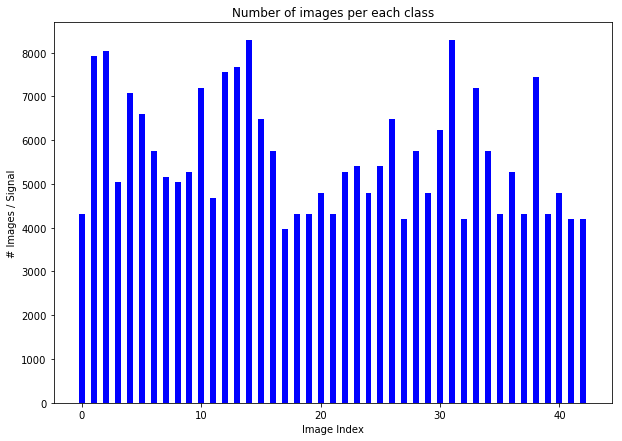

In [19]:
count = pd.value_counts(y_train).sort_index()
    
stats_barchart(y_train, n_classes, count)

In [20]:
result = pd.DataFrame()
result['SignIndex'] = count.index
result['Counts'] = count.values
result['Signal'] = list_signals['SignName'][count.index]

result = result.sort_values(by=['Counts'], ascending=True)
result = result.reset_index(drop=True)

result.head(n=10)

,SignIndex,Counts,Signal
0,17,3960,No entry
1,42,4200,End of no passing by vehicles over 3.5 metric ...
2,32,4200,End of all speed and passing limits
3,27,4200,Pedestrians
4,41,4200,End of no passing
5,39,4320,Keep left
6,37,4320,Go straight or left
7,35,4320,Ahead only
8,19,4320,Dangerous curve to the left
9,18,4320,General caution


As it can be seen above, the differences between classes has been reduced. Furthermore, each image has been randomly modified after been multiplied by 3.

By doing that, we increased the number of examples of the dataset without overfitting our model.

Shuffle the training set so that we do not obtain entire minibatches of highly correlated examples

In [21]:
X_train, y_train = shuffle(X_train, y_train)

### Setup TensorFlow

In [22]:
import tensorflow as tf

EPOCHS = 100
BATCH_SIZE = 128

### Implementing LeNet-5

Implement the [LeNet-5](http://yann.lecun.com/exdb/lenet/) neural network architecture.

### Input
The LeNet architecture accepts a 32x32xC image as input, where C is the number of color channels. Since the images are in the RGB space, C is equal to 3.

### Architecture
**Layer 1: Convolutional.** The output shape should be 28x28x6.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 14x14x6.

**Layer 2: Convolutional.** The output shape should be 10x10x16.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 5x5x16.

**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D.

**Layer 3: Fully Connected.** This should have 120 outputs.

**Activation.** Your choice of activation function.

**Layer 4: Fully Connected.** This should have 84 outputs.

**Activation.** Your choice of activation function.

**Layer 5: Fully Connected (Logits).** This should have 10 outputs.

### Output
Return the result of the 2nd fully connected layer.

In [23]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Features and Labels
Train LeNet to classify [GTSRB](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset) data.

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.

In [24]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

### Training Pipeline
Create a training pipeline that uses the model to classify GTSRB data.

In [25]:
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

### Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

In [26]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train and validate the Model
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.

In [27]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        train_accuracy = evaluate(X_train, y_train)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Train Accuracy = {:.3f}".format(train_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.847
Train Accuracy = 0.854

EPOCH 2 ...
Validation Accuracy = 0.876
Train Accuracy = 0.913

EPOCH 3 ...
Validation Accuracy = 0.886
Train Accuracy = 0.930

EPOCH 4 ...
Validation Accuracy = 0.890
Train Accuracy = 0.947

EPOCH 5 ...
Validation Accuracy = 0.913
Train Accuracy = 0.959

EPOCH 6 ...
Validation Accuracy = 0.915
Train Accuracy = 0.964

EPOCH 7 ...
Validation Accuracy = 0.916
Train Accuracy = 0.971

EPOCH 8 ...
Validation Accuracy = 0.918
Train Accuracy = 0.974

EPOCH 9 ...
Validation Accuracy = 0.927
Train Accuracy = 0.973

EPOCH 10 ...
Validation Accuracy = 0.932
Train Accuracy = 0.977

EPOCH 11 ...
Validation Accuracy = 0.907
Train Accuracy = 0.977

EPOCH 12 ...
Validation Accuracy = 0.922
Train Accuracy = 0.979

EPOCH 13 ...
Validation Accuracy = 0.918
Train Accuracy = 0.982

EPOCH 14 ...
Validation Accuracy = 0.920
Train Accuracy = 0.982

EPOCH 15 ...
Validation Accuracy = 0.929
Train Accuracy = 0.981

EPOCH 16 ...
Validati

### Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [28]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Train Accuracy = {:.3f}".format(train_accuracy))
    print("Validation Accuracy = {:.3f}".format(validation_accuracy))
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Train Accuracy = 0.990
Validation Accuracy = 0.934
Test Accuracy = 0.925


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [29]:
import os
from skimage.transform import resize

filePath = ['test_images/' + file for file in os.listdir('test_images')]
test_images = []

for img in filePath:
    image = plt.imread(img)
    image = resize(image,(32,32,3),mode='constant')
    test_images.append(image)

#### Signals before preprocessing

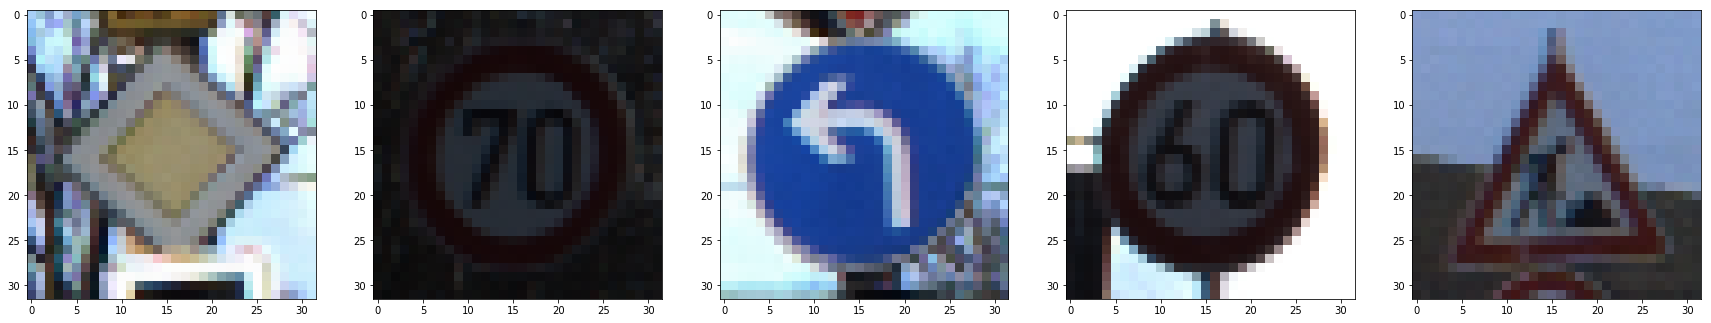

In [30]:
f, axarr = plt.subplots(1,5, figsize=(30,15))
for i in range(5):
    axarr[i].imshow(test_images[i])

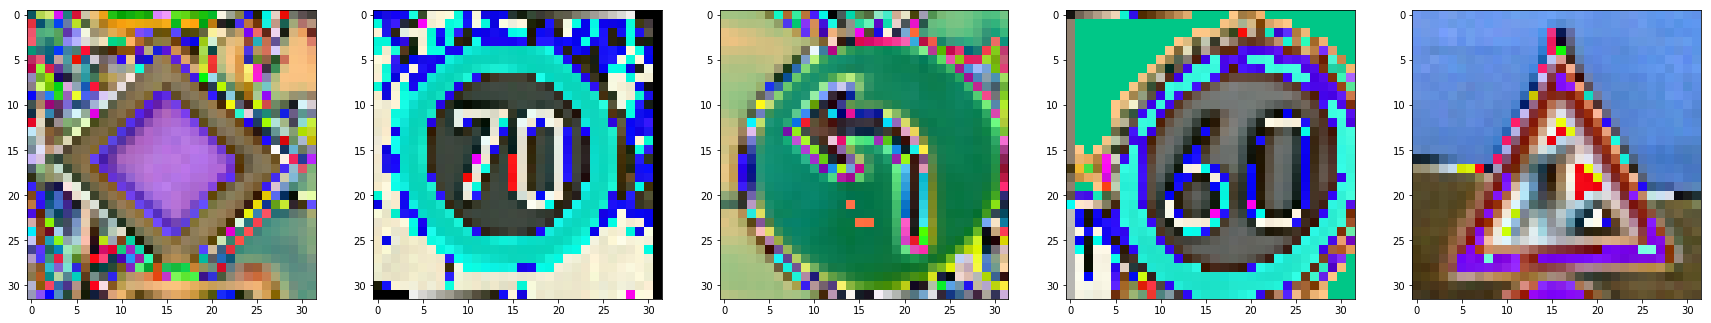

In [33]:
test_images_norm = normalize_dataset(test_images)

for i in range(len(test_images_norm)):
    test_images_norm[i] = random_transform(test_images_norm[i])
    
f, axarr = plt.subplots(1,5, figsize=(30,15))
for i in range(5):
    axarr[i].imshow(test_images_norm[i])

In [36]:
test_labels = np.array([12, 4, 34, 3, 25])

### Predict the Sign Type for Each Image

In [62]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    predictions = sess.run(logits, feed_dict={x: test_images_norm})
    
predicted = []
    
for prediction in predictions:
    predicted.append(np.argmax(prediction))

In [74]:
correct = 0

for i in range(len(test_labels)):
    print("Real signal: ", list_signals['SignName'][test_labels[i]])
    print("Predicted signal: ", list_signals['SignName'][predicted[i]])
    if(test_labels[i] != predicted[i]):
        print("Wrong!\n")
    else:
        print("Good!\n")
        correct += 1


Real signal:  Priority road
Predicted signal:  Priority road
Good!

Real signal:  Speed limit (70km/h)
Predicted signal:  Speed limit (30km/h)
Wrong!

Real signal:  Turn left ahead
Predicted signal:  Turn left ahead
Good!

Real signal:  Speed limit (60km/h)
Predicted signal:  Speed limit (60km/h)
Good!

Real signal:  Road work
Predicted signal:  Road work
Good!



### Analyze Performance

In [76]:
accuracy = correct / len(test_labels)

print("Accuracy: {:.3f}".format(accuracy))

Accuracy: 0.800


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [125]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    sm_prob = tf.nn.softmax(logits)
    predictions = sess.run(sm_prob, feed_dict={x: test_images_norm})
    probabilities = sess.run(tf.nn.top_k(tf.constant(predictions), k=5))

In [126]:
result = pd.DataFrame()
result['Real'] = test_labels

for i in range(len(probabilities[0])):
    result['Class{}'.format(i)] = probabilities[1][:,i]
    result['Pred{}'.format(i)] = probabilities[0][:,i]
    result['Pred{}'.format(i)] = result['Pred{}'.format(i)].map('{:.8f}'.format)
    

In [127]:
result.head()

,Real,Class0,Pred0,Class1,Pred1,Class2,Pred2,Class3,Pred3,Class4,Pred4
0,12,12,1.00000000,0,0.00000000,1,0.00000000,2,0.00000000,3,0.00000000
1,4,1,0.99828941,4,0.00171039,0,0.00000014,7,0.00000004,8,0.00000000
2,34,34,1.00000000,0,0.00000000,1,0.00000000,2,0.00000000,3,0.00000000
3,3,3,1.00000000,5,0.00000000,15,0.00000000,2,0.00000000,1,0.00000000
4,25,25,1.00000000,30,0.00000000,22,0.00000000,29,0.00000000,0,0.00000000


### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")